In [1]:
import pandas as pd
import numpy as np
import re
import os
import matplotlib.pyplot as plt
import duckdb
import pyCLIF as pc
import pySBT as t1code
from tqdm import tqdm
from datetime import datetime
from tableone import TableOne, load_dataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con = pc.load_config()


Loaded configuration from config.json
{'site_name': 'RUSH', 'tables_path': 'C:/Users/vchaudha/Downloads/rush_parquet/', 'file_type': 'parquet', 'your_site_timezone': 'US/Central'}
Imported SBT Helper!
Loaded configuration from config.json


In [2]:
cohort = pd.read_csv('../output/intermediate/study_cohort.csv')
t1_cohort = cohort.copy()

In [3]:
# Construct the full directory path
directory_path = os.path.join("../output/final/", pc.helper["site_name"], "SAT_standard")

# Create the directory if it doesn't exist
if not os.path.exists(directory_path):
    os.makedirs(directory_path)
    print(f"Directory '{directory_path}' created.")
else:
    print(f"Directory '{directory_path}' already exists.")

Directory '../output/final/RUSH\SAT_standard' created.


In [4]:
cohort['sat_delivery_pass_fail'] = cohort['sat_delivery_pass_fail'].map({0:1,1:1})
cohort['sat_screen_pass_fail'] = cohort['sat_screen_pass_fail'].map({0:1,1:1})

In [5]:
# Ensure 'event_time' is in datetime format
cohort["event_time"] = pd.to_datetime(cohort["event_time"])
cohort["admission_dttm"] = pd.to_datetime(cohort["admission_dttm"], utc=True)
cohort["discharge_dttm"] = pd.to_datetime(cohort["discharge_dttm"], utc=True)

# Ensure the data is sorted by 'hosp_id_day_key' and 'event_time'
cohort = cohort.sort_values(by=["hospitalization_id", "event_time"]).reset_index(
    drop=True
)

cohort["device_category_ffill"] = cohort.groupby("hospitalization_id")[
    "device_category"
].ffill()
cohort["location_category_ffill"] = cohort.groupby("hospitalization_id")[
    "location_category"
].ffill()

active_sedation_n_col = [
    "fentanyl",
    "propofol",
    "lorazepam",
    "midazolam",
    "hydromorphone",
    "morphine",
]

for col in active_sedation_n_col:
    if col not in cohort.columns:
        cohort[col] = np.nan
        print(
            f"Column '{col}' is missing. Please check your CLIF Meds table — it might be missing, or it's okay if your site doesn't use it."
        )


# Fill forward the meds by hospitalization columns by 'hosp_id'
cohort[
    ["fentanyl", "propofol", "lorazepam", "midazolam", "hydromorphone", "morphine"]
] = cohort.groupby("hospitalization_id")[
    ["fentanyl", "propofol", "lorazepam", "midazolam", "hydromorphone", "morphine"]
].ffill()

# Ensure the min value is greater than 0
cohort["min_sedation_dose"] = cohort[
    ["fentanyl", "propofol", "lorazepam", "midazolam", "hydromorphone", "morphine"]
].min(axis=1, skipna=True)
cohort["min_sedation_dose_2"] = (
    cohort[
        ["fentanyl", "propofol", "lorazepam", "midazolam", "hydromorphone", "morphine"]
    ]
    .where(
        cohort[
            [
                "fentanyl",
                "propofol",
                "lorazepam",
                "midazolam",
                "hydromorphone",
                "morphine",
            ]
        ]
        > 0
    )
    .min(axis=1, skipna=True)
)
cohort["min_sedation_dose_non_ops"] = cohort[
    ["propofol", "lorazepam", "midazolam"]
].min(axis=1, skipna=True)
cohort["min_sedation_dose_non_ops"] = cohort["min_sedation_dose_non_ops"].fillna(0)

# Fill forward the paralytic by hospitalization columns by 'hosp_id'
cohort[["cisatracurium", "vecuronium", "rocuronium"]] = cohort.groupby(
    "hospitalization_id"
)[["cisatracurium", "vecuronium", "rocuronium"]].ffill()
# paralytic max to remove from consideration
cohort["max_paralytics"] = (
    cohort[["cisatracurium", "vecuronium", "rocuronium"]]
    .max(axis=1, skipna=True)
    .fillna(0)
)


# Fill Rass
cohort[["rass"]] = cohort.groupby("hospitalization_id")[["rass"]].ffill()

# Ensure the data is sorted again by 'hosp_id_day_key' and 'event_time'
cohort = cohort.sort_values(by=["hospitalization_id", "event_time"]).reset_index(
    drop=True
)

#### Identify eligible days

In [6]:
def process_cohort(df):
    df = df.sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)
    df['device_category_ffill'] = df.groupby('hospitalization_id')['device_category'].ffill()
    df['location_category_ffill'] = df.groupby('hospitalization_id')['location_category'].ffill()
    # Ensure 'event_time' is datetime
    df['event_time'] = pd.to_datetime(df['event_time'])
   
    df['all_conditions_check'] = (
            (df['device_category_ffill'].str.lower() == 'imv') &
            (df['min_sedation_dose_2'] > 0) &
            (df['location_category_ffill'].str.lower() == 'icu') &
            (df['max_paralytics'] <= 0)
        ).astype(int)

    # Initialize result list
    result = []

    vented_day = df[(df['device_category'] == 'imv')]['hosp_id_day_key'].unique()
    # Group by 'hospitalization_id' and 'date'
    grouped_hosp = df[df['hosp_id_day_key'].isin(vented_day)].groupby(['hospitalization_id', df['event_time'].dt.normalize()])
    
    # Use tqdm for the outer loop to show progress
    for (hosp_id, date), group in tqdm(grouped_hosp, desc='Processing Hospitalizations by Date'):
        group = group.sort_values('event_time')

        # Get the entire hospitalization data for the current hospitalization_id
        temp_df = df[df['hospitalization_id'] == hosp_id].sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)

        # Define start and end times for the current day
        # Start time is 10 PM of the previous day
        start_time = date - pd.Timedelta(days=1) + pd.Timedelta(hours=22)
        # End time is 6 AM of the current day
        end_time = date + pd.Timedelta(hours=6)

        # Filter data in this time window for the entire hospitalization
        mask_time = (temp_df['event_time'] >= start_time) & (temp_df['event_time'] <= end_time)
        df_time_window = temp_df[mask_time].copy()

        if df_time_window.empty:
            continue

        # Use the existing 'device_category_ffill' and 'location_category_ffill' columns
        df_time_window['all_conditions_met'] = (df_time_window['all_conditions_check']>0
        )

        # If no times where all conditions are met, skip
        if not df_time_window['all_conditions_met'].any():
            continue

        # Ensure data is sorted by 'event_time'
        df_time_window = df_time_window.sort_values('event_time').reset_index(drop=True)

        # Create a group identifier for continuous periods where conditions are met
        df_time_window['condition_met_group'] = (df_time_window['all_conditions_met'] != df_time_window['all_conditions_met'].shift()).cumsum()

        # Filter rows where all conditions are met
        df_conditions = df_time_window[df_time_window['all_conditions_met']].copy()
        if df_conditions.empty:
            continue

        # Group by 'condition_met_group' to identify continuous periods
        grouped_conditions = df_conditions.groupby('condition_met_group')

        found_four_hours = False
        for group_id, group_df in grouped_conditions:
            group_df = group_df.reset_index(drop=True)

            # Calculate the duration of each continuous period where all conditions are met
            group_df['duration'] = group_df['event_time'].diff().fillna(pd.Timedelta(seconds=0))
            group_df['cumulative_duration'] = group_df['duration'].cumsum()
            total_duration = group_df['cumulative_duration'].iloc[-1]

            if total_duration >= pd.Timedelta(hours=4):
                # Calculate the exact event_time when cumulative duration reaches four hours
                cumulative_duration = pd.Timedelta(seconds=0)
                for idx in range(len(group_df)):
                    cumulative_duration += group_df['duration'].iloc[idx]
                    if cumulative_duration >= pd.Timedelta(hours=4):
                        event_time_at_4_hours = group_df['event_time'].iloc[idx]
                        break

                # Append to result
                result.append({
                    'hospitalization_id': hosp_id,
                    'current_day_key': date,
                    'event_time_at_4_hours': event_time_at_4_hours
                })
                found_four_hours = True
                # Since we found a period of at least 4 hours continuous conditions met, we can proceed to the next day
                break  # Exit the loop over condition_met_group
        if found_four_hours:
            continue  # Proceed to the next day

    # Convert result to DataFrame for better representation
    result_df = pd.DataFrame(result)
    return result_df

result_df = process_cohort(cohort)
print('Encounter days with at least 4 hours of conditions met from 10 PM to 6 AM:', len(result_df))

Processing Hospitalizations by Date: 100%|██████████| 18387/18387 [02:53<00:00, 105.78it/s]

Encounter days with at least 4 hours of conditions met from 10 PM to 6 AM: 7955


In [7]:
# Merge the result back into the cohort DataFrame
cohort = cohort.merge(result_df[['hospitalization_id', 'current_day_key', 'event_time_at_4_hours']], 
                      how='left', 
                      left_on=['hospitalization_id', cohort['event_time'].dt.normalize()], 
                      right_on=['hospitalization_id', 'current_day_key'])

# Initialize 'eligible_event' column with NaN and used for validation of exact time the event of 4 hr completed
cohort['eligible_event'] = np.nan
has_event_time = cohort['event_time_at_4_hours'].notna()
for (hosp_id, date), group in cohort[has_event_time].groupby(['hospitalization_id', cohort['event_time'].dt.normalize()]):
    event_time_at_4_hours = group['event_time_at_4_hours'].iloc[0]
    subset = cohort[(cohort['hospitalization_id'] == hosp_id) & (cohort['event_time'] >= event_time_at_4_hours)]
    if not subset.empty:
        idx = subset['event_time'].idxmin()
        cohort.loc[idx, 'eligible_event'] = 1
    else:
        subset = cohort[cohort['hospitalization_id'] == hosp_id]
        idx = subset['event_time'].idxmax()
        cohort.loc[idx, 'eligible_event'] = 1

# fix where last row should not be eligible
cohort = cohort.sort_values(['hospitalization_id', 'event_time']).reset_index(drop=True)
for hosp_id, group in cohort.groupby('hospitalization_id'):
    last_idx = group.index[-1]
    if cohort.loc[last_idx, 'eligible_event'] == 1:
        cohort.loc[last_idx, 'eligible_event'] = np.nan


# Flag all that date rows where eligible_event = 1
filtered_cohort = cohort[cohort['eligible_event'] == 1][['hosp_id_day_key', 'eligible_event']]
merged_cohort = cohort.merge(filtered_cohort, on='hosp_id_day_key', how='left', suffixes=('', '_filtered'))
merged_cohort['on_vent_and_sedation'] = merged_cohort['eligible_event_filtered'].fillna(0).astype(int)
merged_cohort = merged_cohort.drop(columns=['eligible_event_filtered'])

del filtered_cohort,result_df

In [8]:
merged_cohort['eligible_event'].value_counts()

eligible_event
1.0    7943
Name: count, dtype: int64

In [9]:
merged_cohort[merged_cohort['on_vent_and_sedation']==1]['hosp_id_day_key'].nunique()

7943

In [10]:
df = merged_cohort[merged_cohort['on_vent_and_sedation']==1].sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)  

df['rank_sedation'] = np.nan
for hosp_id_day_key, hosp_data in tqdm(df[df['on_vent_and_sedation'] == 1].groupby('hosp_id_day_key'), desc='Processing hosp_id_day_keys'):
    zero_mask = hosp_data['min_sedation_dose'] == 0
    ranks = zero_mask.cumsum() * zero_mask
    df.loc[hosp_data.index, 'rank_sedation'] = ranks.replace(0, np.nan)


df['rank_sedation_non_ops'] = np.nan
for hosp_id_day_key, hosp_data in tqdm(df[df['on_vent_and_sedation'] == 1].groupby('hosp_id_day_key'), desc='Processing hosp_id_day_keys'):
    zero_mask = hosp_data['min_sedation_dose_non_ops'] == 0
    ranks = zero_mask.cumsum() * zero_mask
    df.loc[hosp_data.index, 'rank_sedation_non_ops'] = ranks.replace(0, np.nan)

Processing hosp_id_day_keys: 100%|██████████| 7943/7943 [00:08<00:00, 924.83it/s] 


In [11]:
#quick rass check
df['rass'] = df['rass'].astype(float)
df['rass'].value_counts()

rass
-1.0    75564
-2.0    74212
 0.0    67780
-4.0    61040
-3.0    57339
 1.0    45040
-5.0    37693
 2.0    32480
 3.0     5834
 4.0      710
Name: count, dtype: int64

#### SAT EHR Flags

In [12]:
# Setup
med_columns      = ['fentanyl', 'propofol', 'lorazepam', 'midazolam', 'hydromorphone', 'morphine']
med_columns2     = ['propofol', 'lorazepam', 'midazolam']
flags = [
    'SAT_EHR_delivery',
    'SAT_modified_delivery',
    'SAT_rass_nonneg_30',
    'SAT_med_halved_rass_pos',
    'SAT_no_meds_rass_pos_45',  # new: no meds & rass >=0 in 45 min
    'SAT_rass_first_neg_30_last45_nonneg'
]
for f in flags:
    df[f] = np.nan

vent_df = df[df['on_vent_and_sedation'] == 1]
delta30 = pd.Timedelta(minutes=30)
delta45 = pd.Timedelta(minutes=45)

# Main loop
for key, group in tqdm(vent_df.groupby('hosp_id_day_key'), desc='Processing hosp_id_day_key'):
    grp = group.sort_values('event_time')
    times = grp['event_time'].values
    ranks = grp['rank_sedation'].values
    idxs  = grp.index

    for idx, current_time, rank in zip(idxs, times, ranks):
        if pd.isna(rank):
            continue

        # Define windows
        fw30 = grp[(grp['event_time'] >= current_time) & (grp['event_time'] <= current_time + delta30)]
        fw45 = grp[(grp['event_time'] >= current_time) & (grp['event_time'] <= current_time + delta45)]
        pr30 = grp[(grp['event_time'] >= current_time - delta30) & (grp['event_time'] <  current_time)]

        # ICU+IMV check
        imv_ok = (fw30['device_category_ffill'] == 'imv').all()
        icu_ok = (fw30['location_category_ffill'] == 'icu').all()

        if imv_ok and icu_ok:
            # No meds at all in next 30 min
            meds_ok  = (fw30[med_columns].isna() | (fw30[med_columns] == 0)).all().all()
            if meds_ok:
                df.at[idx, 'SAT_EHR_delivery'] = 1

            # No subset meds
            meds2_ok = (fw30[med_columns2].isna() | (fw30[med_columns2] == 0)).all().all()
            if meds2_ok:
                df.at[idx, 'SAT_modified_delivery'] = 1

            # RASS >= 0 in next 30 min
            rass30 = fw30['rass'].dropna()
            if not rass30.empty and (rass30 >= 0).all():
                df.at[idx, 'SAT_rass_nonneg_30'] = 1

            # New: meds halved & last RASS45 >= 0
            if not pr30.empty and not fw30.empty:
                # Compute 50% thresholds
                half_max = pr30[med_columns].max() * 0.5

                # Only check non-NaN, non-zero meds in forward window
                halved_ok = True
                for med in med_columns:
                    vals = fw30[med].dropna()
                    vals = vals[vals != 0]  # ignore zero doses
                    if not vals.empty and not (vals <= half_max[med]).all():
                        halved_ok = False
                        break

                # Last non-null RASS in 45 window
                rass45 = fw45['rass'].dropna()
                rass45_ok = not rass45.empty and rass45.iloc[-1] >= 0

                if halved_ok and rass45_ok:
                    df.at[idx, 'SAT_med_halved_rass_pos'] = 1

            # New: no meds & last RASS45 >= 0
            if meds_ok:
                rass45 = fw45['rass'].dropna()
                rass45_ok = not rass45.empty and rass45.iloc[-1] >= 0
                if rass45_ok:
                    df.at[idx, 'SAT_no_meds_rass_pos_45'] = 1
            
                # --- new flag: first RASS <0 in next 30 & last RASS ≥0 in next 45 ---
            rass45 = fw45['rass'].dropna()
            if not rass30.empty and not rass45.empty:
                first_rass30 = rass30.iloc[0]
                last_rass45  = rass45.iloc[-1]
                if first_rass30 < 0 and last_rass45 >= 0:
                    df.at[idx, 'SAT_rass_first_neg_30_last45_nonneg'] = 1


Processing hosp_id_day_key: 100%|██████████| 7943/7943 [20:15<00:00,  6.53it/s]  


### Delta plot

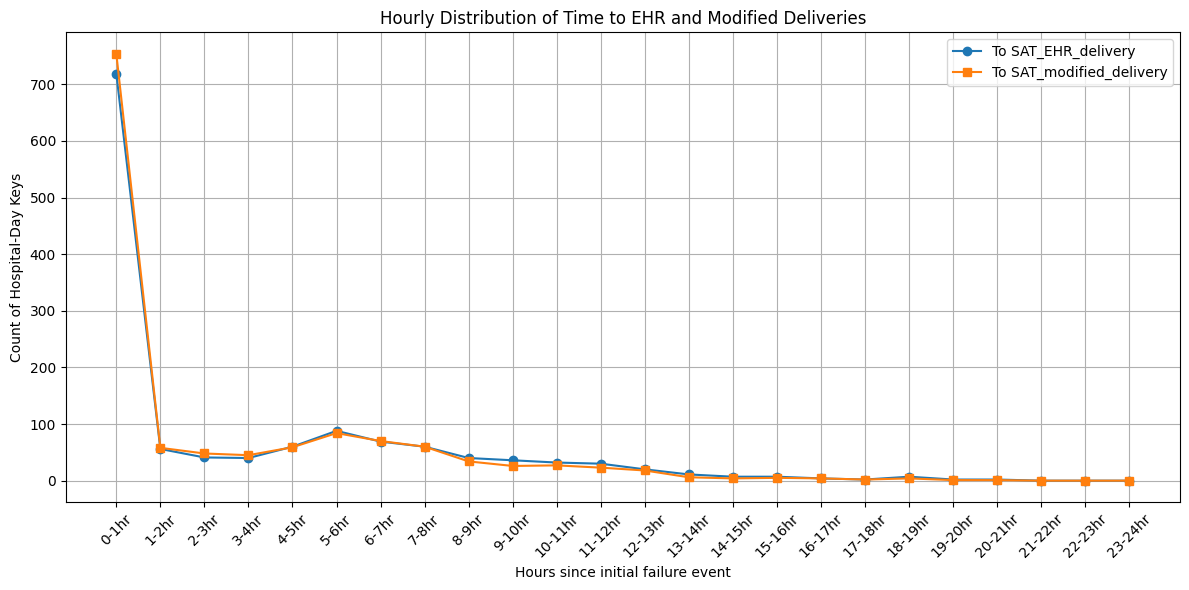

In [13]:

# 1. Identify initial sat failure events and delivery events
mask_initial = (df['sat_delivery_pass_fail'] == 1) | (df['sat_screen_pass_fail'] == 1)
mask_ehr = df['SAT_EHR_delivery'] == 1
mask_mod = df['SAT_modified_delivery'] == 1

initial_times = df[mask_initial].groupby('hosp_id_day_key')['event_time'].min().rename('initial_time')
ehr_times = df[mask_ehr].groupby('hosp_id_day_key')['event_time'].min().rename('ehr_time')
mod_times = df[mask_mod].groupby('hosp_id_day_key')['event_time'].min().rename('mod_time')

# 2. Merge into a single DataFrame and drop incomplete cases
times_df = pd.concat([initial_times, ehr_times, mod_times], axis=1).dropna()

# 3. Convert event_time columns to datetime
for col in ['initial_time', 'ehr_time', 'mod_time']:
    times_df[col] = pd.to_datetime(times_df[col])

# 4. Compute deltas in minutes
times_df['delta_to_ehr'] = (times_df['ehr_time'] - times_df['initial_time']).dt.total_seconds() / 60
times_df['delta_to_mod'] = (times_df['mod_time'] - times_df['initial_time']).dt.total_seconds() / 60

# 5. Filter deltas to positive values within 24 hours (0–1440 minutes)
times_df = times_df[
    (times_df['delta_to_ehr'] >= 0) & (times_df['delta_to_ehr'] <= 1440) &
    (times_df['delta_to_mod'] >= 0) & (times_df['delta_to_mod'] <= 1440)
]

# 6. Bin into hourly intervals
bins = list(range(0, 24*60 + 1, 60))  # [0, 60, 120, ..., 1440]
labels = [f'{i}-{i+1}hr' for i in range(24)]

ehr_binned = pd.cut(times_df['delta_to_ehr'], bins=bins, labels=labels, right=False)
mod_binned = pd.cut(times_df['delta_to_mod'], bins=bins, labels=labels, right=False)

ehr_counts = ehr_binned.value_counts().sort_index()
mod_counts = mod_binned.value_counts().sort_index()

# 7. Plot both lines hour-wise
plt.figure(figsize=(12, 6))
plt.plot(labels, ehr_counts.values, marker='o', label='To SAT_EHR_delivery')
plt.plot(labels, mod_counts.values, marker='s', label='To SAT_modified_delivery')
plt.xlabel('Hours since initial failure event')
plt.ylabel('Count of Hospital-Day Keys')
plt.title('Hourly Distribution of Time to EHR and Modified Deliveries')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

binned_df = pd.DataFrame({
    'hour_bin': labels,
    'count_to_SAT_EHR_delivery': ehr_counts.values,
    'count_to_SAT_modified_delivery': mod_counts.values
})
binned_df.to_csv(f'{directory_path}/binned_delta_counts.csv', index=False)

#### Icu los calculation

In [14]:
icu_los = cohort[['hospitalization_id', 'event_time', 'location_category_ffill']]
icu_los = icu_los.sort_values(by=['hospitalization_id', 'event_time']).reset_index(drop=True)

icu_los['segment'] = (icu_los['location_category_ffill'] != icu_los['location_category_ffill'].shift()).cumsum()

icu_segments = icu_los[icu_los['location_category_ffill'].str.lower() == 'icu'].groupby(
    ['hospitalization_id', 'segment']
).agg(
    location_start=('event_time', 'first'),
    location_end=('event_time', 'last')
).reset_index()

icu_segments['los_days'] = (icu_segments['location_end'] - icu_segments['location_start']).dt.total_seconds() / (24 * 3600)
icu_los_per_encounter = icu_segments[['hospitalization_id', 'los_days']]

total_icu_los_per_hosp = icu_los_per_encounter.groupby('hospitalization_id', as_index=False).agg(
    ICU_LOS=('los_days', 'sum')
)
total_icu_los_per_hosp.shape

(4176, 2)

#### last dishcharge hosptial_id

In [15]:
last_hosp = cohort[['hospitalization_id', 'event_time', 'hospital_id']]

last_hosp = last_hosp.sort_values(by=['hospitalization_id','event_time'], ascending=False).groupby(
    ['hospitalization_id'], as_index=False
).agg(({'hospital_id': 'first'})).reset_index(drop=True)
last_hosp.shape

(4176, 2)

#### Table one df 

In [16]:
main = df[['patient_id', 'hospitalization_id', 'admission_dttm', 'discharge_dttm',
       'age_at_admission', 'discharge_category', 'sex_category',
       'race_category', 'ethnicity_category','hosp_id_day_key']].drop_duplicates()
main.shape

(7943, 10)

In [17]:
main = pd.merge(main, total_icu_los_per_hosp, on='hospitalization_id', how='left')
main = pd.merge(main, last_hosp, on='hospitalization_id', how='left')
main.shape

(7943, 12)

In [18]:
# Columns to group by
group_cols = [
 'hosp_id_day_key'
]

max_cols = ['sat_screen_pass_fail','sat_delivery_pass_fail','SAT_EHR_delivery', 'SAT_modified_delivery', 'eligible_event','SAT_EHR_delivery',
    'SAT_modified_delivery',
    'SAT_rass_nonneg_30',
    'SAT_med_halved_rass_pos',
    'SAT_no_meds_rass_pos_45','SAT_rass_first_neg_30_last45_nonneg']
agg_dict = {col: 'max' for col in max_cols}

df_grouped = df.groupby(group_cols).agg(agg_dict).reset_index()

df_grouped = df_grouped.sort_values('hosp_id_day_key').reset_index(drop=True)

df_grouped['sat_flowsheet_delivery_flag'] = np.where(
    (
        (df_grouped['sat_screen_pass_fail'] == 1) |
        (df_grouped['sat_delivery_pass_fail'] == 1)
    ) &
    (df_grouped['eligible_event'] == 1),
    1,  # Flag is set to 1 (True) if conditions are met
    np.nan   # Flag nan
)

final_df = main.merge(df_grouped, on='hosp_id_day_key', how='inner')
final_df.shape

(7943, 22)

In [19]:
for x in [
    "sat_delivery_pass_fail",
    "sat_screen_pass_fail",
    "SAT_EHR_delivery",

    "SAT_modified_delivery",
    "eligible_event",

    "sat_flowsheet_delivery_flag",
    "SAT_rass_first_neg_30_last45_nonneg",
    "SAT_rass_nonneg_30",
    "SAT_med_halved_rass_pos",
    "SAT_no_meds_rass_pos_45",
]:

    print(final_df[x].value_counts())

    print()

sat_delivery_pass_fail
1.0    2386
Name: count, dtype: int64

sat_screen_pass_fail
1.0    4234
Name: count, dtype: int64

SAT_EHR_delivery
1.0    2907
Name: count, dtype: int64

SAT_modified_delivery
1.0    4815
Name: count, dtype: int64

eligible_event
1.0    7943
Name: count, dtype: int64

sat_flowsheet_delivery_flag
1.0    4248
Name: count, dtype: int64

SAT_rass_first_neg_30_last45_nonneg
1.0    3074
Name: count, dtype: int64

SAT_rass_nonneg_30
1.0    3808
Name: count, dtype: int64

SAT_med_halved_rass_pos
1.0    1656
Name: count, dtype: int64

SAT_no_meds_rass_pos_45
1.0    1652
Name: count, dtype: int64



#### concordance

In [20]:
con_df = final_df.copy()
for col in ['SAT_EHR_delivery', 'SAT_modified_delivery', 'sat_flowsheet_delivery_flag' , "SAT_rass_nonneg_30",
    "SAT_med_halved_rass_pos",
    "SAT_no_meds_rass_pos_45",'SAT_rass_first_neg_30_last45_nonneg']:
    con_df[col].fillna(0, inplace=True)

metrics_list = []

for col in ['SAT_EHR_delivery', 'SAT_modified_delivery' ,"SAT_rass_nonneg_30",
    "SAT_med_halved_rass_pos",
    "SAT_no_meds_rass_pos_45",'SAT_rass_first_neg_30_last45_nonneg']:
    y_true = con_df['sat_flowsheet_delivery_flag']
    y_pred = con_df[col]

    # raw confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    total = cm.sum()

    # derived metrics
    accuracy    = (tp + tn) / total
    precision   = tp / (tp + fp) if (tp + fp) else 0
    recall      = tp / (tp + fn) if (tp + fn) else 0
    f1          = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    specificity = tn / (tn + fp) if (tn + fp) else 0

    # normalized matrix for percentages
    cm_pct = cm / total * 100  # percent

    # plot
    labels = ["No Delivery", "Delivery"]
    fig, ax = plt.subplots()
    im = ax.imshow(cm, cmap=plt.cm.Blues)

    # ticks and labels
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel(f"{col} Flag")
    ax.set_ylabel("Flowsheet Delivery Flag")
    ax.set_title(f"Concordance: flowsheet vs {col}")

    # annotate each cell with count + percent
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            pct   = cm_pct[i, j]
            ax.text(
                j, i,
                f"{count}\n({pct:.1f}%)",
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max()/2 else "black"
            )

    # colorbar
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

    # save and close
    plot_path = os.path.join(directory_path, f"confusion_matrix_{col}.png")
    fig.savefig(plot_path, bbox_inches='tight')
    plt.close(fig)

    # print metrics
    print(f"--- Concordance for {col} ---")
    print(f"Accuracy    : {accuracy:.3f}")
    print(f"Precision   : {precision:.3f}")
    print(f"Recall      : {recall:.3f}")
    print(f"F1 Score    : {f1:.3f}")
    print(f"Specificity : {specificity:.3f}\n")

    metrics_list.append({
        "Column": col,
        "TP": tp, "FP": fp, "FN": fn, "TN": tn,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Specificity": specificity
    })

# save summary
metrics_df = pd.DataFrame(metrics_list)
metrics_df.to_csv(os.path.join(directory_path, "delivery_concordance_summary.csv"), index=False)

--- Concordance for SAT_EHR_delivery ---
Accuracy    : 0.652
Precision   : 0.755
Recall      : 0.517
F1 Score    : 0.614
Specificity : 0.807

--- Concordance for SAT_modified_delivery ---
Accuracy    : 0.613
Precision   : 0.622
Recall      : 0.705
F1 Score    : 0.660
Specificity : 0.507

--- Concordance for SAT_rass_nonneg_30 ---
Accuracy    : 0.582
Precision   : 0.622
Recall      : 0.557
F1 Score    : 0.588
Specificity : 0.610

--- Concordance for SAT_med_halved_rass_pos ---
Accuracy    : 0.588
Precision   : 0.794
Recall      : 0.310
F1 Score    : 0.445
Specificity : 0.908

--- Concordance for SAT_no_meds_rass_pos_45 ---
Accuracy    : 0.589
Precision   : 0.798
Recall      : 0.310
F1 Score    : 0.447
Specificity : 0.910

--- Concordance for SAT_rass_first_neg_30_last45_nonneg ---
Accuracy    : 0.596
Precision   : 0.669
Recall      : 0.484
F1 Score    : 0.562
Specificity : 0.725



In [21]:
final_df.to_csv('../output/intermediate/final_df_SAT.csv', index=False)

#### table one print

In [22]:
categorical_columns = ['sex_category', 'race_category', 'ethnicity_category','discharge_category']
non_categorical_columns = ['age_at_admission',  'ICU_LOS', 'Inpatient_LOS']

final_df['admission_dttm'] = pd.to_datetime(final_df['admission_dttm'],utc=True)
final_df['discharge_dttm'] = pd.to_datetime(final_df['discharge_dttm'],utc=True)

In [23]:
### SAT FLAG Table 1


sat_flow_t1 = final_df[final_df['sat_flowsheet_delivery_flag'] == 1][[ 'hospitalization_id', 'admission_dttm', 'discharge_dttm', 'age_at_admission', 'discharge_category', 'sex_category','race_category', 'ethnicity_category','ICU_LOS']].drop_duplicates()
sat_flow_t1['Inpatient_LOS'] = (sat_flow_t1['discharge_dttm'] - sat_flow_t1['admission_dttm']).dt.total_seconds() / (24 * 3600)

if len(sat_flow_t1)>1:
    table1 = TableOne(sat_flow_t1, categorical=categorical_columns, nonnormal=non_categorical_columns, columns=categorical_columns+non_categorical_columns )

    table1.to_csv(f'{directory_path}/table1_sat_flowhseet_{pc.helper["site_name"]}.csv')
    print(table1)

                                                                           Missing           Overall
n                                                                                               1922
sex_category, n (%)              Female                                                   844 (43.9)
                                 Male                                                    1078 (56.1)
race_category, n (%)             American Indian or Alaska Native                            3 (0.2)
                                 Asian                                                      82 (4.3)
                                 Black or African American                                673 (35.0)
                                 Native Hawaiian or Other Pacific Islander                   3 (0.2)
                                 Other                                                    359 (18.7)
                                 Unknown                                                   

In [24]:
### SAT EHR FLAG Table 1

sat_ehr_t1 = final_df[(final_df['SAT_EHR_delivery'] == 1) | (final_df['SAT_modified_delivery'] == 1)][[ 'hospitalization_id', 'admission_dttm', 'discharge_dttm', 'age_at_admission', 'discharge_category', 'sex_category','race_category', 'ethnicity_category','ICU_LOS']].drop_duplicates()
sat_ehr_t1['Inpatient_LOS'] = (sat_ehr_t1['discharge_dttm'] - sat_ehr_t1['admission_dttm']).dt.total_seconds() / (24 * 3600)

if len(sat_ehr_t1)>1:
    table2 = TableOne(sat_ehr_t1, categorical=categorical_columns, nonnormal=non_categorical_columns, columns=categorical_columns+non_categorical_columns )

    table2.to_csv(f'{directory_path}/table1_sat_ehr_{pc.helper["site_name"]}.csv')
    print(table2)

                                                                           Missing           Overall
n                                                                                               2199
sex_category, n (%)              Female                                                   978 (44.5)
                                 Male                                                    1221 (55.5)
race_category, n (%)             American Indian or Alaska Native                            4 (0.2)
                                 Asian                                                      88 (4.0)
                                 Black or African American                                775 (35.2)
                                 Native Hawaiian or Other Pacific Islander                   3 (0.1)
                                 Other                                                    417 (19.0)
                                 Unknown                                                   

In [25]:
### all Table 1

all_t1 = final_df[[ 'hospitalization_id', 'admission_dttm', 'discharge_dttm', 'age_at_admission', 'discharge_category', 'sex_category','race_category', 'ethnicity_category','ICU_LOS']].drop_duplicates()
all_t1['Inpatient_LOS'] = (all_t1['discharge_dttm'] - all_t1['admission_dttm']).dt.total_seconds() / (24 * 3600)

if len(all_t1)>1:
    table3 = TableOne(all_t1, categorical=categorical_columns, nonnormal=non_categorical_columns, columns=categorical_columns+non_categorical_columns )

    table3.to_csv(f'{directory_path}/table1_all_t1_{pc.helper["site_name"]}.csv')
    print(table3)

                                                                           Missing           Overall
n                                                                                               2525
sex_category, n (%)              Female                                                  1129 (44.7)
                                 Male                                                    1396 (55.3)
race_category, n (%)             American Indian or Alaska Native                            4 (0.2)
                                 Asian                                                      98 (3.9)
                                 Black or African American                                896 (35.5)
                                 Native Hawaiian or Other Pacific Islander                   3 (0.1)
                                 Other                                                    465 (18.4)
                                 Unknown                                                   

#### Per hospital stats

In [26]:
# Initialize an empty list to store each hospital's data
data_list = []

# Iterate over unique hospital IDs as strings
for x in final_df['hospital_id'].astype(str).unique():
    # Count of eligible events for this site
    eligible_event_count = final_df[
        (final_df['eligible_event'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]

    # Existing SAT flags counts
    sat_flowsheet_delivery_flag_count = final_df[
        (final_df['sat_flowsheet_delivery_flag'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]
    SAT_modified_delivery_count = final_df[
        (final_df['SAT_modified_delivery'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]
    SAT_EHR_delivery_count = final_df[
        (final_df['SAT_EHR_delivery'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]

    # New SAT flags counts
    SAT_rass_nonneg_30_count = final_df[
        (final_df['SAT_rass_nonneg_30'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]
    SAT_med_halved_rass_pos_count = final_df[
        (final_df['SAT_med_halved_rass_pos'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]
    SAT_no_meds_rass_pos_45_count = final_df[
        (final_df['SAT_no_meds_rass_pos_45'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]
    # New flag: first negative RASS within 30 min, last 45 min non-negative
    SAT_rass_first_neg_30_last45_nonneg_count = final_df[
        (final_df['SAT_rass_first_neg_30_last45_nonneg'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ].shape[0]

    # Unique patients and hospitalizations for each flag
    SAT_EHR_uni_pats = final_df[
        (final_df['SAT_EHR_delivery'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['patient_id'].nunique()
    SAT_EHR_hosp = final_df[
        (final_df['SAT_EHR_delivery'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['hospitalization_id'].nunique()

    SAT_modified_uni_pats = final_df[
        (final_df['SAT_modified_delivery'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['patient_id'].nunique()
    SAT_modified_hosp = final_df[
        (final_df['SAT_modified_delivery'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['hospitalization_id'].nunique()

    SAT_rass_nonneg_30_uni_pats = final_df[
        (final_df['SAT_rass_nonneg_30'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['patient_id'].nunique()
    SAT_rass_nonneg_30_hosp = final_df[
        (final_df['SAT_rass_nonneg_30'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['hospitalization_id'].nunique()

    SAT_med_halved_rass_pos_uni_pats = final_df[
        (final_df['SAT_med_halved_rass_pos'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['patient_id'].nunique()
    SAT_med_halved_rass_pos_hosp = final_df[
        (final_df['SAT_med_halved_rass_pos'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['hospitalization_id'].nunique()

    SAT_no_meds_rass_pos_45_uni_pats = final_df[
        (final_df['SAT_no_meds_rass_pos_45'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['patient_id'].nunique()
    SAT_no_meds_rass_pos_45_hosp = final_df[
        (final_df['SAT_no_meds_rass_pos_45'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['hospitalization_id'].nunique()

    # Unique for the new flag
    SAT_rass_first_neg_30_last45_nonneg_uni_pats = final_df[
        (final_df['SAT_rass_first_neg_30_last45_nonneg'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['patient_id'].nunique()
    SAT_rass_first_neg_30_last45_nonneg_hosp = final_df[
        (final_df['SAT_rass_first_neg_30_last45_nonneg'] == 1) &
        (final_df['hospital_id'].astype(str) == x)
    ]['hospitalization_id'].nunique()

    # Calculate percentages safely
    if eligible_event_count > 0:
        percent_sat_flowsheet_delivery_flag = sat_flowsheet_delivery_flag_count / eligible_event_count * 100
        percent_SAT_modified_delivery = SAT_modified_delivery_count / eligible_event_count * 100
        percent_SAT_EHR_delivery = SAT_EHR_delivery_count / eligible_event_count * 100
        percent_SAT_rass_nonneg_30 = SAT_rass_nonneg_30_count / eligible_event_count * 100
        percent_SAT_med_halved_rass_pos = SAT_med_halved_rass_pos_count / eligible_event_count * 100
        percent_SAT_no_meds_rass_pos_45 = SAT_no_meds_rass_pos_45_count / eligible_event_count * 100
        percent_SAT_rass_first_neg_30_last45_nonneg = SAT_rass_first_neg_30_last45_nonneg_count / eligible_event_count * 100
    else:
        percent_sat_flowsheet_delivery_flag = percent_SAT_modified_delivery = 0
        percent_SAT_EHR_delivery = percent_SAT_rass_nonneg_30 = 0
        percent_SAT_med_halved_rass_pos = percent_SAT_no_meds_rass_pos_45 = 0
        percent_SAT_rass_first_neg_30_last45_nonneg = 0

    # Append the metrics for this hospital
    data_list.append({
        'Site_Name_Hosp': pc.helper["site_name"] + '_' + x,
        '%_of_SAT_flowsheet_delivery_flag': percent_sat_flowsheet_delivery_flag,
        '%_of_SAT_modified_delivery': percent_SAT_modified_delivery,
        '%_of_SAT_EHR_delivery': percent_SAT_EHR_delivery,
        '%_of_SAT_rass_nonneg_30': percent_SAT_rass_nonneg_30,
        '%_of_SAT_med_halved_rass_pos': percent_SAT_med_halved_rass_pos,
        '%_of_SAT_no_meds_rass_pos_45': percent_SAT_no_meds_rass_pos_45,
        '%_of_SAT_rass_first_neg_30_last45_nonneg': percent_SAT_rass_first_neg_30_last45_nonneg,
        'eligible_event_count': eligible_event_count,
        'sat_flowsheet_delivery_flag_count': sat_flowsheet_delivery_flag_count,
        'SAT_modified_delivery_count': SAT_modified_delivery_count,
        'SAT_EHR_delivery_count': SAT_EHR_delivery_count,
        'SAT_rass_nonneg_30_count': SAT_rass_nonneg_30_count,
        'SAT_med_halved_rass_pos_count': SAT_med_halved_rass_pos_count,
        'SAT_no_meds_rass_pos_45_count': SAT_no_meds_rass_pos_45_count,
        'SAT_rass_first_neg_30_last45_nonneg_count': SAT_rass_first_neg_30_last45_nonneg_count,
        'SAT_EHR_unique_patients': SAT_EHR_uni_pats,
        'SAT_EHR_unique_hospitalizations': SAT_EHR_hosp,
        'SAT_modified_unique_patients': SAT_modified_uni_pats,
        'SAT_modified_unique_hospitalizations': SAT_modified_hosp,
        'SAT_rass_nonneg_30_unique_patients': SAT_rass_nonneg_30_uni_pats,
        'SAT_rass_nonneg_30_unique_hospitalizations': SAT_rass_nonneg_30_hosp,
        'SAT_med_halved_rass_pos_unique_patients': SAT_med_halved_rass_pos_uni_pats,
        'SAT_med_halved_rass_pos_unique_hospitalizations': SAT_med_halved_rass_pos_hosp,
        'SAT_no_meds_rass_pos_45_unique_patients': SAT_no_meds_rass_pos_45_uni_pats,
        'SAT_no_meds_rass_pos_45_unique_hospitalizations': SAT_no_meds_rass_pos_45_hosp,
        'SAT_rass_first_neg_30_last45_nonneg_unique_patients': SAT_rass_first_neg_30_last45_nonneg_uni_pats,
        'SAT_rass_first_neg_30_last45_nonneg_unique_hospitalizations': SAT_rass_first_neg_30_last45_nonneg_hosp,
    })

# Create a DataFrame from the list and export
final_data_df = pd.DataFrame(data_list)
final_data_df.to_csv(f'{directory_path}/sat_stats_{pc.helper["site_name"]}.csv', index=False)
# Display the final DataFrame
final_data_df.T


,0
Site_Name_Hosp,RUSH_RUMC
%_of_SAT_flowsheet_delivery_flag,53.481052
%_of_SAT_modified_delivery,60.619413
%_of_SAT_EHR_delivery,36.598263
%_of_SAT_rass_nonneg_30,47.941584
%_of_SAT_med_halved_rass_pos,20.848546
%_of_SAT_no_meds_rass_pos_45,20.798187
%_of_SAT_rass_first_neg_30_last45_nonneg,38.700743
eligible_event_count,7943
sat_flowsheet_delivery_flag_count,4248


# New Table 1 Code

In [27]:
# Aggregate functions
def documented(series):
    return "Documented" if series.notna().any() else "Not Documented"

def age_bucket(mean_age):
    if pd.isna(mean_age):
        return None
    elif mean_age < 40:
        return "18-39"
    elif mean_age < 60:
        return "40-59"
    elif mean_age < 80:
        return "60-79"
    else:
        return "80+"

# Clean 'language_name' to only "English", "Spanish", or "Other"
def categorize_language(lang):
    if re.search(r'english', str(lang), re.IGNORECASE):
        return 'English'
    elif re.search(r'spanish', str(lang), re.IGNORECASE):
        return 'Spanish'
    else:
        return 'Other'

t1_col = [
    "patient_id",
    "hospitalization_id",
    "hosp_id_day_key",
    "age_at_admission",    "sex_category",    "race_category",    "ethnicity_category",    "language_name",    "weight_kg",
    "height_cm", "cisatracurium",    "vecuronium",    "rocuronium",    "dobutamine",    "dopamine",    "epinephrine",
    "fentanyl",    "hydromorphone",    "isoproterenol",    "lorazepam",    "midazolam",    "milrinone",    "morphine",
    "norepinephrine",    "phenylephrine",    "propofol",    "vasopressin",    "angiotensin",     "rass", "gcs_total"
]

medication_columns = [
    "rass", "gcs_total", "cisatracurium", "vecuronium", "rocuronium",
    "dobutamine", "dopamine", "epinephrine", "fentanyl", "hydromorphone",
    "isoproterenol", "lorazepam", "midazolam", "milrinone", "morphine",
    "norepinephrine", "phenylephrine", "propofol", "vasopressin", "angiotensin"
]

demographic_columns = ["sex_category", "race_category", "ethnicity_category", "language_name"]

continuous_cols = [
    "rass", "gcs_total", "cisatracurium", "vecuronium", "rocuronium",
    "dobutamine", "dopamine", "epinephrine", "fentanyl", "hydromorphone",
    "isoproterenol", "lorazepam", "midazolam", "milrinone", "morphine",
    "norepinephrine", "phenylephrine", "propofol", "vasopressin",
    "angiotensin", "bmi"
]

drugs = [
    "cisatracurium", "vecuronium", "rocuronium",
    "dobutamine", "dopamine", "epinephrine", "fentanyl", "hydromorphone",
    "isoproterenol", "lorazepam", "midazolam", "milrinone", "morphine",
    "norepinephrine", "phenylephrine", "propofol", "vasopressin", "angiotensin"
]

# Apply the transformation
t1_cohort[drugs] = t1_cohort[drugs].applymap(lambda x: x if x > 0 else np.nan)

t1_cohort['bmi'] = t1_cohort['weight_kg'] / ((t1_cohort['height_cm'] / 100) ** 2)

# Apply the function to 'language_name'
t1_cohort['language_name'] = t1_cohort['language_name'].apply(categorize_language)
t1_cohort['rass'] = t1_cohort['rass'].astype(float)

#### Table 1 By ID for Categorical

In [28]:
for x in ['hospitalization_id', 'patient_id']:
    t1_summary = t1_cohort.groupby(x).agg(
        {
            "age_at_admission": "mean",
            **{col: documented for col in medication_columns},
            **{col: "first" for col in demographic_columns}
        }
    )

    t1_summary["age_bucket"] = t1_summary["age_at_admission"].apply(age_bucket)
    t1_summary = t1_summary.drop(columns=["age_at_admission"])
    t1_summary = t1_summary.reset_index()

    summary_df = t1code.manual_categorical_tableone(
        t1_summary, 
        medication_columns + demographic_columns + ["age_bucket"]
    )

    if x == 'hospitalization_id':
        summary_df.to_csv(f"{directory_path}/table1_hospitalization_id_categorical.csv", index=False)
    else:
        summary_df.to_csv(f"{directory_path}/table1_patient_id_categorical.csv", index=False)

#### Table 1 By ID for Continuous

In [29]:
hospitalization_summary = None
patient_summary = None

hosp = (
    t1_cohort
      .groupby("hospitalization_id")
      .agg(
        {
          **{c: "median" for c in continuous_cols}
        }
      )
      .reset_index()
)

patient = (
    t1_cohort
      .groupby("patient_id")
      .agg(
        {
          **{c: "median" for c in continuous_cols}
        }
      )
      .reset_index()
)

# Build for hospitalization level and patient level
hospitalization_summary = t1code.manual_tableone(hosp, continuous_cols)
patient_summary = t1code.manual_tableone(patient, continuous_cols)

hospitalization_summary.to_csv(f"{directory_path}/table1_hospitalization_id_continuous.csv", index=False)
patient_summary.to_csv(f"{directory_path}/table1_patient_id_continuous.csv", index=False)

#### Table 1 By Days for Categorical

In [30]:
for x in tqdm(
    [
        "eligible_event",
        "SAT_EHR_delivery",
        "SAT_modified_delivery"
    ]
):
    ids_to_use = final_df[final_df[x]==1].hosp_id_day_key.unique()
    # Groupby aggregation by hospitalization_id
    t1_summary = t1_cohort[t1_cohort['hosp_id_day_key'].isin(ids_to_use)].groupby("hosp_id_day_key").agg(
        {
            "age_at_admission": "mean",
            **{col: documented for col in medication_columns},
            **{col: "first" for col in demographic_columns},
        }
    )

    # Apply age bucketing
    t1_summary["age_bucket"] = t1_summary["age_at_admission"].apply(age_bucket)

    # Drop raw age if you don't need it
    t1_summary = t1_summary.drop(columns=["age_at_admission"])

    # Reset index if needed
    t1_summary = t1_summary.reset_index()

    summary_df = t1code.manual_categorical_tableone(
        t1_summary, 
        medication_columns + demographic_columns + ["age_bucket"]
    )
    summary_df.to_csv(f"{directory_path}/table1_{x}_categorical.csv", index=False)


100%|██████████| 3/3 [00:28<00:00,  9.55s/it]


In [31]:
for x in tqdm(
    [
        "eligible_event",
        "SAT_EHR_delivery",
        "SAT_modified_delivery",
         "SAT_rass_nonneg_30",
    "SAT_med_halved_rass_pos",
    "SAT_no_meds_rass_pos_45",
    'SAT_rass_first_neg_30_last45_nonneg'
    ]
):
    # --- filter to only the days in this subcohort
    ids = final_df.loc[final_df[x] == 1, "hosp_id_day_key"].unique()
    sub = t1_cohort[t1_cohort["hosp_id_day_key"].isin(ids)]

    # --- 1) Day-level medians + flags + demographics
    day_summary = (
        sub.groupby("hosp_id_day_key")
        .agg({**{c: "median" for c in continuous_cols}})
        .reset_index()
    )
    summary_df = t1code.manual_tableone(day_summary, continuous_cols)
    summary_df.to_csv(f"{directory_path}/table1_{x}_continuous.csv", index=False)

100%|██████████| 7/7 [00:02<00:00,  2.61it/s]


### Sofa T1's

In [32]:
import pySofa as sofa
sofa.pyCLIF2.helper

continuous_cols_sofa = [ 'sofa_cv_97', 'sofa_coag',
       'sofa_liver', 'sofa_resp_pf', 'sofa_resp_pf_imp', 'sofa_resp',
       'sofa_cns', 'sofa_renal', 'sofa_total']

Loaded configuration from config.json


In [33]:
mapping_ids = pd.read_csv('../output/intermediate/hospitalization_to_block_df.csv')
encounter_dict = dict(zip(mapping_ids['hospitalization_id'].astype(str), mapping_ids['encounter_block'].astype(str)))
mapping_ids.head()

,hospitalization_id,encounter_block
0,100169127277,1
1,100190011993,2
2,100203388036,3
3,100235169364,4
4,100189173875,5


In [34]:
encounter_level_sofa = cohort[['hospitalization_id', 'admission_dttm',
       'discharge_dttm']].drop_duplicates().rename(columns={'admission_dttm':'start_dttm','discharge_dttm':'stop_dttm'})
encounter_level_sofa = pc.convert_datetime_columns_to_site_tz(encounter_level_sofa, pc.helper['your_site_timezone'])
encounter_level_sofa.head()

start_dttm: Your timezone is UTC, Converting to your site timezone (US/Central).
start_dttm: null count = 0
stop_dttm: Your timezone is UTC, Converting to your site timezone (US/Central).
stop_dttm: null count = 0


,hospitalization_id,start_dttm,stop_dttm
0,33,2024-12-03 11:38:00-06:00,2024-12-11 07:53:00-06:00
216,773,2024-05-14 11:38:00-05:00,2024-06-04 12:44:00-05:00
537,933,2022-09-10 23:53:00-05:00,2022-09-20 18:24:00-05:00
967,993,2024-06-26 18:06:00-05:00,2024-07-22 12:07:00-05:00
1608,1077,2023-12-25 02:28:00-06:00,2024-01-29 14:17:00-06:00


In [35]:
sout = sofa.compute_sofa(
    encounter_level_sofa,
    tables_path=None,
    use_hospitalization_id = False,
    id_mapping = mapping_ids,
    group_by_id = "encounter_block"
)
encounter_level_sofa_t1 = t1code.manual_tableone(sout, continuous_cols_sofa)
encounter_level_sofa_t1.to_csv(f'{directory_path}/encounter_level_sofa_t1.csv',index=False)

2025-05-01 17:34:20,318 - INFO - Starting SOFA computation for 4176 rows


using id_col will be used for groupbyz: encounter_block


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2025-05-01 17:34:25,489 - INFO - Loaded 260175 lab rows


Data loaded successfully from C:/Users/vchaudha/Downloads/rush_parquet/clif_labs.parquet


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Data loaded successfully from C:/Users/vchaudha/Downloads/rush_parquet/clif_vitals.parquet


2025-05-01 17:34:41,472 - INFO - Loaded 2047246 vitals rows


2025-05-01 17:34:44,798 - INFO - Created vitals summary
2025-05-01 17:34:44,801 - INFO - Imputed pao2 from spo2


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Data loaded successfully from C:/Users/vchaudha/Downloads/rush_parquet/clif_patient_assessments.parquet


2025-05-01 17:34:47,635 - INFO - Loaded 200628 GCS rows


Data loaded successfully from C:/Users/vchaudha/Downloads/rush_parquet/clif_medication_admin_continuous.parquet


2025-05-01 17:34:49,235 - INFO - Loaded 322305 med rows


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Data loaded successfully from C:/Users/vchaudha/Downloads/rush_parquet/clif_respiratory_support.parquet


2025-05-01 17:35:07,356 - INFO - Loaded 1435191 resp rows


FIO2_SET mean= 0.4481587621262835 is within the required range
Missing ratio of p_f (po2_arterial_min / fio2_max):  0.08273381294964029
Missing ratio of p_f_imputed (pao2_imputed_min / fio2_max):  0.017985611510791366
Missing ratio of s_f (spo2_min / fio2_max): 0.004796163069544364

Most of the missing values in p_f_imputed are caused by pao2_imputed_min, which is set to NaN when spo2>97


2025-05-01 17:36:37,348 - INFO - Loaded 238778 CRRT rows


Data loaded successfully from C:/Users/vchaudha/Downloads/rush_parquet/clif_crrt_therapy.parquet


2025-05-01 17:36:37,475 - INFO - Finished computing SOFA for 4170 ids


In [ ]:

for x in tqdm(['on_vent_and_sedation',"sat_delivery_pass_fail",'SAT_EHR_delivery', 'SAT_modified_delivery' , "SAT_rass_nonneg_30",
    "SAT_med_halved_rass_pos",
    "SAT_no_meds_rass_pos_45",'SAT_rass_first_neg_30_last45_nonneg']):

        day_df = df[df[x]==1][['hospitalization_id','hosp_id_day_key','event_time']].drop_duplicates()

        if day_df.empty:
                continue
        # Create start_dttm as current_day at 00:00:00
        day_df['start_dttm'] = pd.to_datetime(day_df['event_time']).dt.normalize()
        # Create end_dttm as current_day at 23:59:59
        day_df['stop_dttm'] = day_df['start_dttm'] + pd.Timedelta(hours=23, minutes=59, seconds=59)
        day_df = pc.convert_datetime_columns_to_site_tz(day_df, pc.helper['your_site_timezone'])

        day_sofa = sofa.compute_sofa(
                                day_df,
                                tables_path=None,
                                use_hospitalization_id = False,
                                id_mapping = mapping_ids,
                                group_by_id = "hosp_id_day_key"
                        )
        
        day_sofa_t1 = t1code.manual_tableone(day_sofa, continuous_cols_sofa)
        day_sofa_t1.to_csv(f'{directory_path}/{x}_sofa_t1.csv',index=False)
        
        


  0%|          | 0/8 [00:00<?, ?it/s]2025-05-01 18:26:37,514 - INFO - Starting SOFA computation for 458085 rows


start_dttm: null count = 0
stop_dttm: null count = 0
using id_col will be used for groupbyz: hosp_id_day_key


#### Thank You!!! upload to box :)